# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out_il.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("m.postnikov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


In [4]:
import itertools
from heapq import *

class PriorityQueue:
    REMOVED = '<removed-task>'
    
    def __init__(self):
        self.pq = []                         # list of entries arranged in a heap
        self.entry_finder = {}               # mapping of tasks to entries
        self.counter = itertools.count()
       
    def empty(self):
        return len(self.entry_finder) == 0
    
    def push_task(self, task, priority=0):
        'Add a new task or update the priority of an existing task'
        if task in self.entry_finder:
            self.remove_task(task)
        count = next(self.counter)
        entry = [priority, count, task]
        self.entry_finder[task] = entry
        heappush(self.pq, entry)

    def remove_task(self, task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, count, task = heappop(self.pq)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task
        raise KeyError('pop from an empty priority queue')
    
    def print_pq(self):
        'Print priority queue.'
        print self.pq

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [5]:
from sklearn.neighbors import KDTree

UNDEFINED = 1e7

def dist(p1, p2):
    return sqrt(sum((p1 - p2)**2))

def distances2(x, y):
    dists = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            dists[i][j] = dist(x[i], y[j])
    return dists

def update(x, neighbors, point, unprocessed, coredist, seeds, reach_dist):
    for neighbor in neighbors:
        if neighbor in unprocessed:
            newreachdist = max(coredist, dist(x[point], x[neighbor]))
            if ((reach_dist[neighbor] == UNDEFINED) or (newreachdist < reach_dist[neighbor])):
                reach_dist[neighbor] = newreachdist
                seeds.push_task(neighbor, newreachdist)
                        
def optics(x, epsilon=0.3, min_pts=4):
    ordered = []
    reach_dist = [UNDEFINED] * len(x)
    
    tree = KDTree(x, leaf_size=10, metric='euclidean')
    neighbors, distances = tree.query_radius(x, r=epsilon, count_only=False, return_distance=True, sort_results=True)
    core_dist = map(lambda z: z[min_pts] if (len(z) > min_pts) else UNDEFINED, distances)
    
    unprocessed = set(range(0, len(x)))
    while unprocessed:
        point = unprocessed.pop()
        ordered.append(point)
        if (core_dist[point] != UNDEFINED):
            seeds = PriorityQueue()
            update(x, neighbors[point], point, unprocessed, core_dist[point], seeds, reach_dist)
            while not seeds.empty():
                neighbor = seeds.pop_task()
                if (neighbor in unprocessed): unprocessed.remove(neighbor)
                ordered.append(neighbor)
                if (core_dist[neighbor] != UNDEFINED):
                    update(x, neighbors[neighbor], neighbor, unprocessed, core_dist[neighbor], seeds, reach_dist)
    return np.array(reach_dist), np.array(core_dist), np.array(ordered)

def clusterize(reach_dist, core_dist, ordered, epsilon):
    label = -1
    labels = [label]*len(ordered)
    for x_id in ordered:
        if reach_dist[x_id] > epsilon:
            if core_dist[x_id] <= epsilon:
                label += 1
                labels[x_id] = label
        else:
            labels[x_id] = label
    return np.array(labels), label+1

class ClusteringOptics():
    
    def __init__(self, epsilon = 0.2, min_pts = 4, eps_cl = -1):
        if (epsilon < 0) or (min_pts < 1): raise
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.eps_cl = eps_cl
        if (eps_cl < 0) or (eps_cl > epsilon): self.eps_cl = epsilon
        return
        
    def fit(self, x, y=None):
        reach_dist, self.core_dist, self.ordered = optics(x, self.epsilon, self.min_pts)
        reach_dist[reach_dist == UNDEFINED] = self.epsilon+0.05
        self.labels, self.n_clusters = clusterize(reach_dist, self.core_dist, self.ordered, self.eps_cl)
        self.reach_dists = reach_dist
        self.points = x
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        if self.n_clusters == 0: return np.array([-1]*len(x))
        dists = distances2(x, self.points[self.labels >= 0])
        return self.labels[self.labels >= 0][dists.argmin(axis=1)]
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.labels

In [6]:
def plot_cls(cls):
    pl.figure(figsize=(17,3))
    pl.title("$min pts$ = %d, $eps$ = %.2f, $n clusters$ = %d" % (cls.min_pts, cls.eps_cl, cls.n_clusters))
    pl.plot(range(len(cls.reach_dists)), cls.reach_dists[np.arange(len(cls.reach_dists))[cls.ordered]])
    pl.show()

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

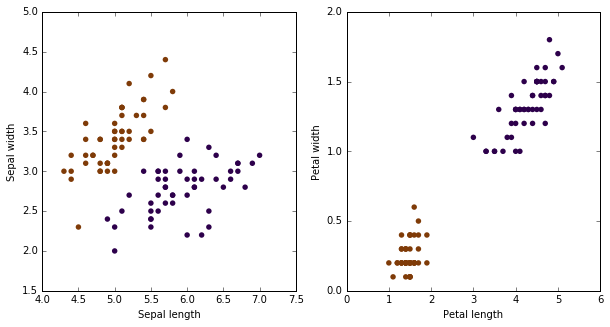

In [7]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

Adjusted Rand index for iris is: 1.00


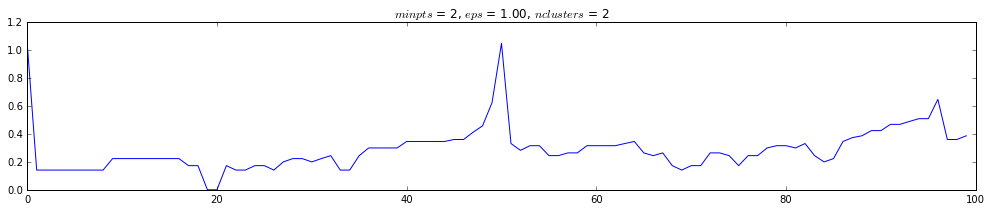

In [8]:
cls = ClusteringOptics(epsilon=1, min_pts = 2)
pred_iris = cls.fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)
plot_cls(cls)

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [9]:
def distances(x):
    dists = np.zeros((len(x), len(x)))
    for i in range(0, len(x)):
        for j in range(i+1, len(x)):
            d = dist(x[i], x[j])
            dists[i][j], dists[j][i] = d, d
    return dists

#silhouette - но он не дает хорошего результата, поэтому посмотрим качество кластеризации в зависимости от параметров
def quality(x, y):
    n_labels = len(np.unique(y))
    if n_labels == 1: return 1
    indexes = np.arange(len(x))
    dists = distances(x)
    silhouette_summ = 0.
    for i, label in enumerate(y):
        a = np.mean([dists[i][y == label]])
        b = min([np.mean([dists[i][y == j]]) for j in range(n_labels) if j != label])
        silhouette_summ += (b - a)/max(a, b)
    return silhouette_summ/len(x)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

21


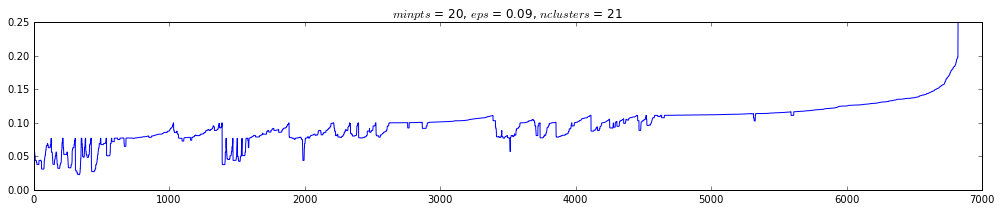

In [11]:
cls = ClusteringOptics(epsilon=0.2, min_pts=20, eps_cl=0.09)
y = cls.fit_predict(x)
print cls.n_clusters
plot_cls(cls)

In [14]:
print quality(x_iris, pred_iris)

0.742198079747


[ 0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35]
0.53613645381
0.685100766388
0.433409393457
0.412345871372
0.372117580092
0.384115615841
0.22649414039
0.198527077698
0.386795118252
1.0
0.247395889426


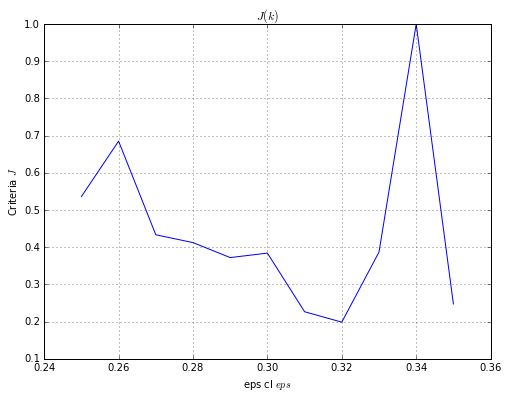

In [23]:
ks = np.linspace(0.25, 0.35, 11)
print ks
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = ClusteringOptics(epsilon=0.5, min_pts=20, eps_cl=k)
    y = cls.fit_predict(x)
    criteria[i] = quality(x[y>=0], y[y>=0])
    print criteria[i]

pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("eps cl $eps$")
pl.grid()
pl.show()

2


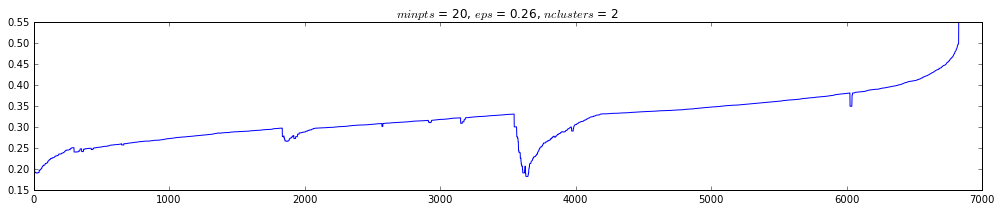

In [26]:
cls = ClusteringOptics(epsilon=0.5, min_pts=20, eps_cl=0.26)
y = cls.fit_predict(x)
print cls.n_clusters
plot_cls(cls)

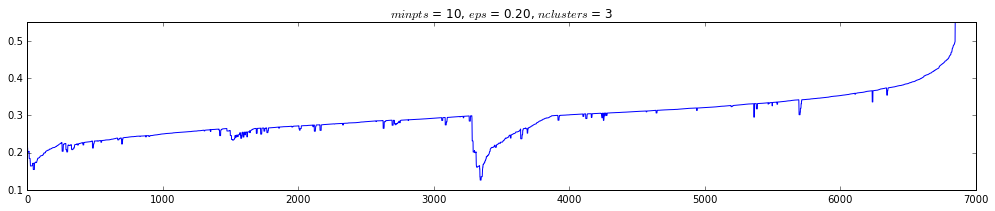

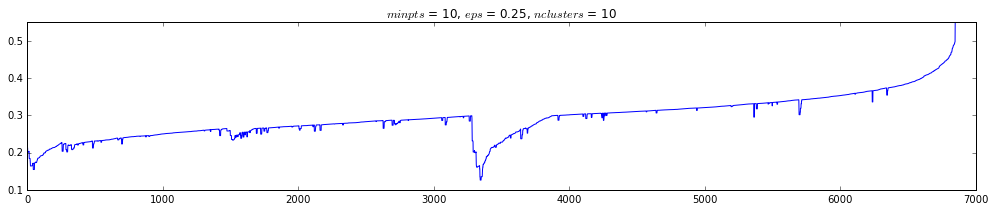

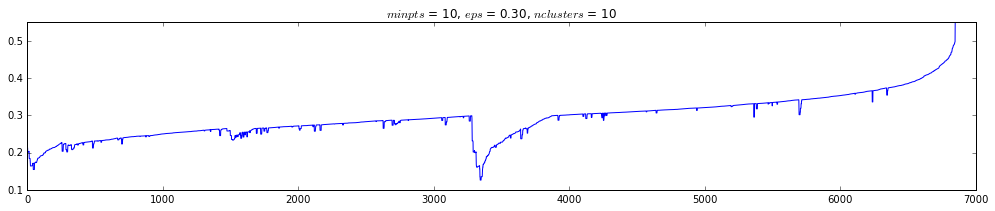

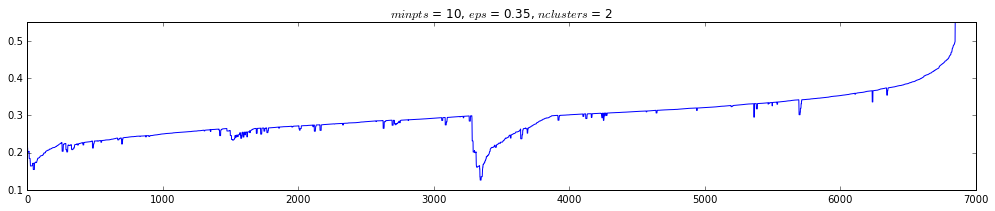

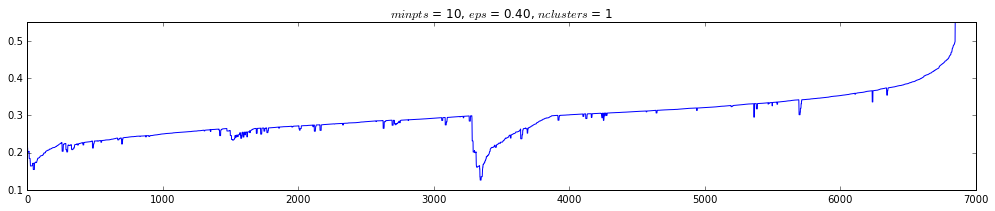

In [22]:
min_pts = 10
eps = [0.2, 0.25, 0.3, 0.35, 0.4] 
criteria = np.zeros(len(eps))

xsl = x

for i, k in enumerate(eps):
    cls = ClusteringOptics(epsilon=0.5, min_pts=min_pts, eps_cl=k)
    y = cls.fit_predict(xsl)
    plot_cls(cls)

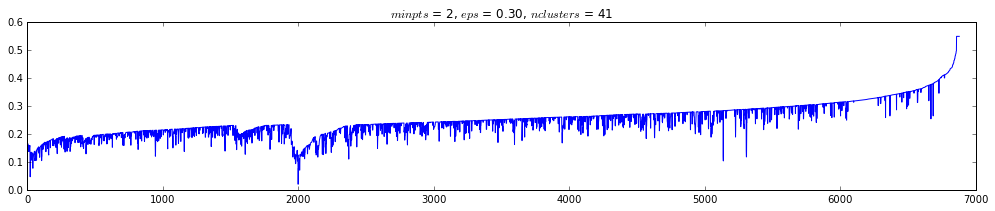

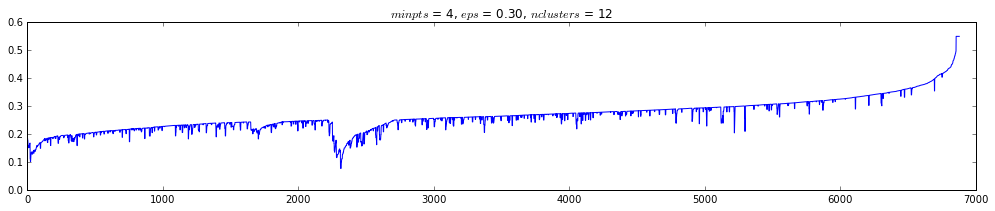

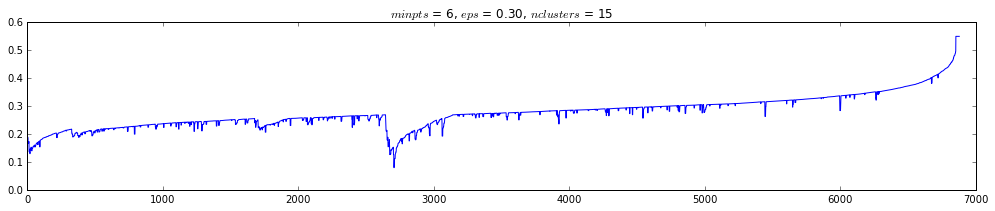

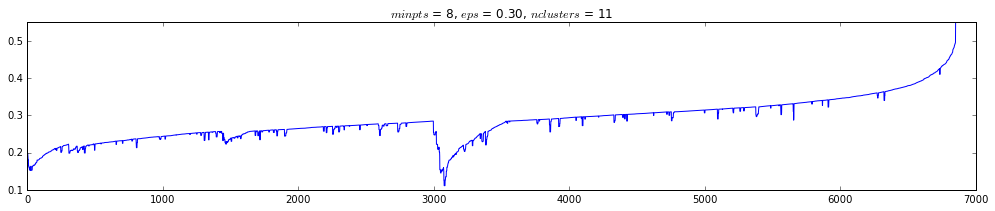

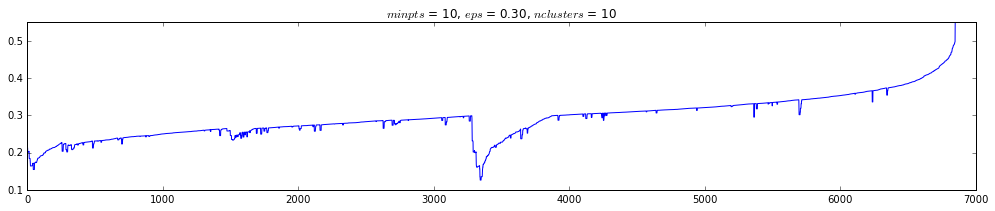

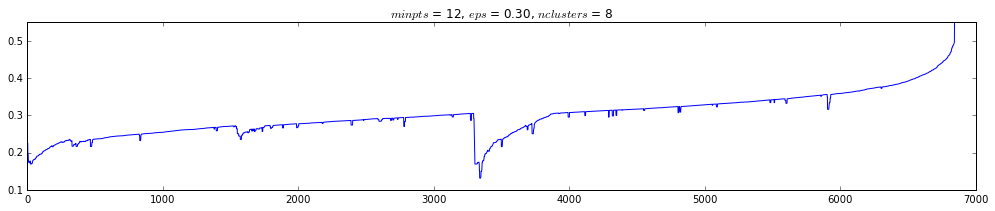

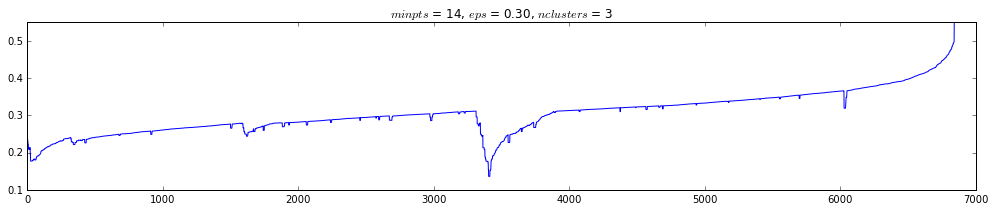

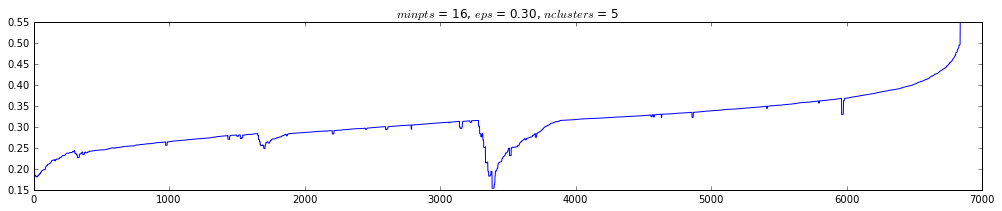

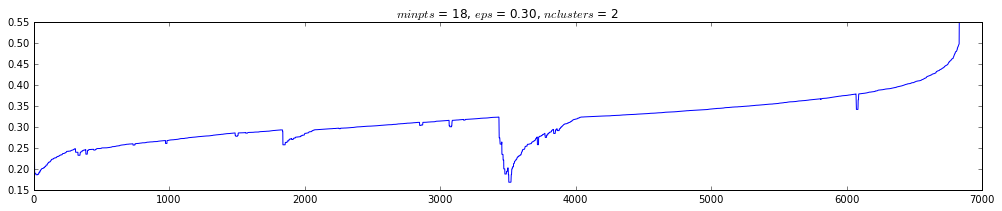

In [23]:
min_pts = range(2,20,2)
eps = 0.3

xsl = x

for i, k in enumerate(min_pts):
    cls = ClusteringOptics(epsilon=0.5, min_pts=k, eps_cl=eps)
    y = cls.fit_predict(xsl)
    plot_cls(cls)
    pl.show()

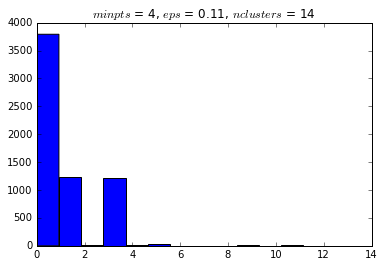

In [18]:
min_pts = 4
eps = [0.11] 

xsl = x

for i, k in enumerate(eps):
    cls = ClusteringOptics(epsilon=0.2, min_pts=min_pts, eps_cl=k)
    y = cls.fit_predict(xsl)
    n = cls.n_clusters
    if n > 0:
        sizes = np.zeros(n)
        for i in range(n):
            sizes[i] = len(y[y==i])
        pl.hist(y[y >= 0], bins = n)
        pl.title("$min pts$ = %d, $eps$ = %.2f, $n clusters$ = %d" % (min_pts, k, n))
        pl.show()


Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

81


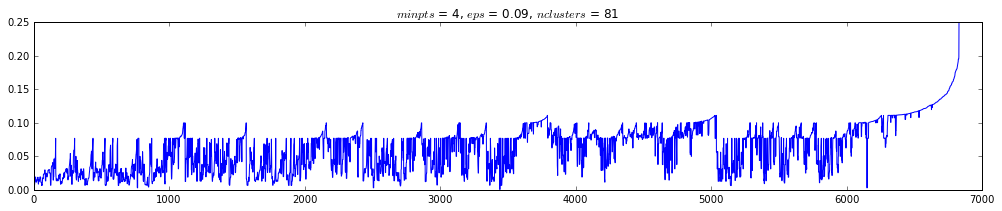

In [23]:
cls = ClusteringOptics(epsilon=0.2, min_pts=4, eps_cl=0.09)
y = cls.fit_predict(x)
k = cls.n_clusters
print k
plot_cls(cls)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5622
[t-SNE] Computed conditional probabilities for sample 2000 / 5622
[t-SNE] Computed conditional probabilities for sample 3000 / 5622
[t-SNE] Computed conditional probabilities for sample 4000 / 5622
[t-SNE] Computed conditional probabilities for sample 5000 / 5622
[t-SNE] Computed conditional probabilities for sample 5622 / 5622
[t-SNE] Mean sigma: 0.058869
[t-SNE] Error after 100 iterations with early exaggeration: 1.603007
[t-SNE] Error after 400 iterations: 1.424657


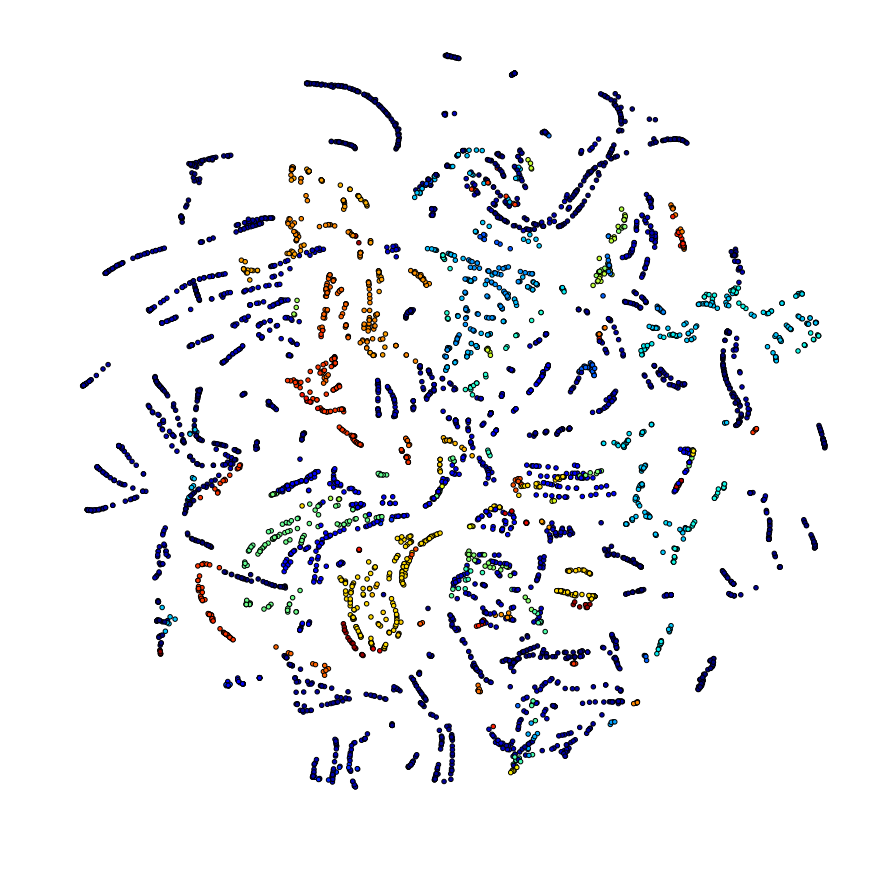

In [24]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x[y>=0])

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), (y[y>=0])))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

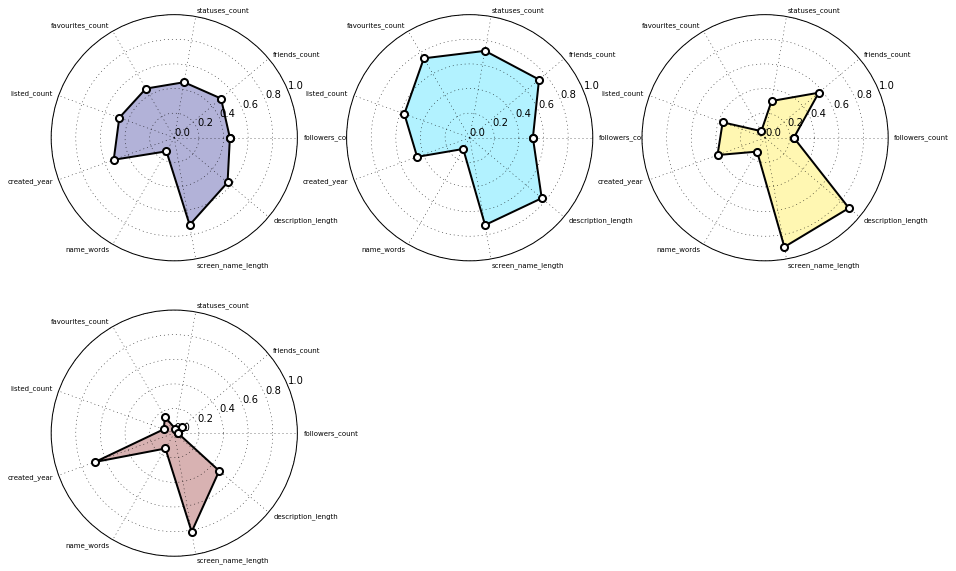

In [27]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)[:9]
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.